# Implementation of a Devito skew self adjoint variable density visco- acoustic isotropic modeling operator <br>-- Linearized Ops --

## This operator is contributed by Chevron Energy Technology Company (2020)

This operator is based on simplfications of the systems presented in:
<br>**Self-adjoint, energy-conserving second-order pseudoacoustic systems for VTI and TTI media for reverse time migration and full-waveform inversion** (2016)
<br>Kenneth Bube, John Washbourne, Raymond Ergas, and Tamas Nemeth
<br>SEG Technical Program Expanded Abstracts
<br>https://library.seg.org/doi/10.1190/segam2016-13878451.1

## Introduction 

The goal of this tutorial set is to generate and prove correctness of modeling and inversion capability in Devito for variable density visco- acoustics using an energy conserving form of the wave equation. We describe how the linearization of the energy conserving *skew self adjoint* system with respect to modeling parameters allows using the same modeling system for all nonlinear and linearized forward and adjoint finite difference evolutions. 

There are three notebooks in this series:

1. *Implementation of a Devito skew self adjoint variable density visco- acoustic isotropic modeling operator -- Nonlinear Ops*
[ssa_01_iso_implementation1.ipynb](ssa_01_iso_implementation1.ipynb)
<br>Implement the nonlinear modeling operations. 

2. *Implementation of a Devito skew self adjoint variable density visco- acoustic isotropic modeling operator -- Linearized Ops*
[ssa_02_iso_implementation2.ipynb](ssa_02_iso_implementation2.ipynb)
<br>Implement the linearized (Jacobian) ```forward``` and ```adjoint``` modeling operations.

3. *Implementation of a Devito skew self adjoint variable density visco- acoustic isotropic modeling operator -- Correctness Testing*
[ssa_03_iso_correctness.ipynb](ssa_03_iso_correctness.ipynb)
<br>Tests the correctness of the implemented operators.

There are similar series of notebooks implementing and testing operators for VTI and TTI anisotropy ([README.md](README.md)).

Below we continue with our *skew self adjoint* wave equation with dissipation only Q attenuation, and linearize the modeling operator with respect to the model parameters (velocity). We show how to implement finite difference evolutions to compute the action of the ```forward``` and ```adjoint``` Jacobian. 

## Outline 
1. Define symbols [[link]](#ln_symbols) 
2. The linearization [[link]](#ln_linearization) 
3. Create the Devito grid and model fields [[link]](#ln_grid_and_model) 
4. Implement the linearized forward operator [[link]](#ln_linearized_forward) 
5. Exercise the linearized forward operator [[link]](#ln_linearized_forward_run) 
6. Implement the linearized adjoint operator [[link]](#ln_linearized_adjoint) 
7. Exercise the linearized adjoint operator [[link]](#ln_linearized_adjoint_run) 

<a id="ln_symbols"></a>
## Table of symbols

| Symbol &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | Description  | Dimensionality | 
|:---|:---|:---|
| $\omega_c = 2 \pi f$ | center angular frequency | constant |
| $v(x,y,z)$   | Total P wave velocity ($v_0+\delta v$) | function of space |
| $v_0(x,y,z)$   | Reference P wave velocity    | function of space |
| $\delta v(x,y,z)$   | Perturbation to P wave velocity    | function of space |
| $b(x,y,z)$   | buoyancy $(1 / \rho)$ | function of space |
| $Q(x,y,z)$   | Attenuation at frequency $\omega_c$ | function of space |
| $P(t,x,y,z)$ | Total pressure wavefield ($P_0+\delta P$)| function of time and space |
| $P_0(t,x,y,z)$ | Reference pressure wavefield | function of time and space |
| $\delta P(t,x,y,z)$ | Perturbation to pressure wavefield | function of time and space |
| $s(t,x,y,z)$ | Source wavefield | function of time, localized in space to source location |
| $R(t,x,y,z)$ | Receiver wavefield | function of time, localized in space to receiver locations |
| $\widetilde{R}(t,x,y,z)$ | Receiver wavefield, time reversed | function of time, localized in space to receiver locations |
| $\Gamma,\ \Gamma^\dagger $ | Receiver interpolation operator, and adjoint | $R(t,x,y,z) = \Gamma\ P(t,x,y,z)$ |
| $\overleftarrow{\partial_t}$ | shifted first derivative wrt $t$ | shifted 1/2 sample backward in time |
| $\partial_{tt}$ | centered second derivative wrt $t$ | time |
| $\overrightarrow{\partial_x},\ \overrightarrow{\partial_y},\ \overrightarrow{\partial_z}$ | + shifted first derivative wrt $x,y,z$ | shifted 1/2 sample forward in space |
| $\overleftarrow{\partial_x},\ \overleftarrow{\partial_y},\ \overleftarrow{\partial_z}$ | - shifted first derivative wrt $x,y,z$ | shifted 1/2 sample backward in space |

## A word about notation 

We use the arrow symbols over derivatives $\overrightarrow{\partial_x}$ as a shorthand notation to indicate that the derivative is taken at a shifted location. For example:

- $\overrightarrow{\partial_x} P(t,x,y,z)$ indicates that the $x$ derivative of $P(t,x,y,z)$ is taken at $P(t,x+\frac{\Delta x}{2},y,z)$.

- $\overleftarrow{\partial_z} P(t,x,y,z)$ indicates that the $z$ derivative of $P(t,x,y,z)$ is taken at $P(t,x,y,z-\frac{\Delta z}{2})$.

- $\overleftarrow{\partial_t} P(t,x,y,z)$ indicates that the $t$ derivative of $P(t,x,y,z)$ is taken at $P(t-\frac{\Delta t}{2},x,y,z)$.

We usually drop the $(t,x,y,z)$ notation from wavefield variables unless required for clarity of exposition, so that $P(t,x,y,z)$ becomes $P$.

## Receiver data

For the Jacobian operator we need to introduce receiver data, linearly interpolated from the pressure wavefield $P(t,x,y,z)$ at $nr$ receiver locations. The receiver gather $R(t,x,y,z)$ can be obtained by applying the linear interpolation operator $\Gamma$ to the pressure wavefield $P(t,x,y,z)$: 

$$
R(t,x,y,z) = \Gamma\ P(t,x,y,z)
$$

This linear interpolation is baked into the Devito [SparseTimeFunction](https://github.com/devitocodes/devito/blob/master/devito/types/sparse.py#L747) classes, as implemented in [PointSource](https://github.com/devitocodes/devito/blob/master/examples/seismic/source.py#L80). 

We will use $\widetilde{R}(t,x,y,z)$ to indicate the time reversed receiver wavefield, that will be injected via the adjoint of the interpolation operator $\Gamma^\dagger$ as a source term for the Jacobian adjoint operator. 

## The Nonlinear operator

The nonlinear operator is the solution to the skew self adjoint scalar isotropic variable density visco- acoustic wave equation shown immediately below, and maps velocity $v$ into the receiver wavefield $R$.

$$
\frac{b}{v^2} \left( \frac{\omega_c}{Q}\overleftarrow{\partial_t}P + \partial_{tt} P \right) =
    \overleftarrow{\partial_x}\left(b\ \overrightarrow{\partial_x} P \right) +
    \overleftarrow{\partial_y}\left(b\ \overrightarrow{\partial_y} P \right) +
    \overleftarrow{\partial_z}\left(b\ \overrightarrow{\partial_z} P \right) + s 
$$

<a id="ln_linearization"></a>
## The Jacobian operator

In this section we linearize about a background model and take the derivative of the nonlinear operator to obtain the Jacobian forward operator. This operator maps a perturbation in velocity $\delta v$ into a perturbation in receiver wavefield $\delta R$.

#### 1. We begin by simplifying notation 
To simplify the treatment below we introduce the operator $L_t[\cdot]$, accounting for the time derivatives inside the parentheses on the left hand side of the wave equation. 

$$
L_t[\cdot] \equiv \frac{\omega_c}{Q} \overleftarrow{\partial_t}[\cdot] + \partial_{tt}[\cdot]
$$

Next we re-write the wave equation using this notation.

$$
\frac{b}{v^2} L_t[P] =
    \overleftarrow{\partial_x}\left(b\ \overrightarrow{\partial_x} P \right) +
    \overleftarrow{\partial_y}\left(b\ \overrightarrow{\partial_y} P \right) +
    \overleftarrow{\partial_z}\left(b\ \overrightarrow{\partial_z} P \right) + s 
$$

#### 2. Linearize
To linearize we treat the total model as the sum of reference and perturbation models $\left(m = m_0 + \delta m\right)$, and the total pressure as the sum of reference and perturbation pressures $\left(P = P_0 + \delta P\right)$.

$$
\frac{b}{(v_0+\delta v)^2} L_t[P_0+\delta P] =
    \overleftarrow{\partial_x}\left(b\ \overrightarrow{\partial_x} (P_0+\delta P) \right) +
    \overleftarrow{\partial_y}\left(b\ \overrightarrow{\partial_y} (P_0+\delta P) \right) +
    \overleftarrow{\partial_z}\left(b\ \overrightarrow{\partial_z} (P_0+\delta P) \right) + s 
$$

Note that *model parameters* for this variable density isotropic visco-acoustic physics is only velocity, we do not treat perturbations to density.

#### 3. Take derivative w.r.t. model parameters
Next we take the derivative with respect to velocity and keep only terms up to first order in the perturbations, and arrive at the following linearized equation:

$$
\frac{b}{v_0^2} L_t\left[\delta P\right] =
    \overleftarrow{\partial_x}\left(b\ \overrightarrow{\partial_x} \delta P \right) +
    \overleftarrow{\partial_y}\left(b\ \overrightarrow{\partial_y} \delta P \right) +
    \overleftarrow{\partial_z}\left(b\ \overrightarrow{\partial_z} \delta P \right) + 
    \frac{2\ b\ \delta v}{v_0^3} L_t\left[P_0\right]
$$

You will note that this is the same equation as used for the nonlinear forward, only now with a different source term. The source $s$ in the equation for the nonlinear forward operator is replaced here by the *Born* source $\frac{\displaystyle 2\ b\ \delta v}{\displaystyle v_0^3} L_t\left[P_0\right]$ for this Jacobian operator.

## The adjoint of the Jacobian operator

In this section we introduce the adjoint of the Jacobian operator. This operator maps a perturbation in receiver wavefield $\delta R$ into a perturbation in velocity $\delta v$.

#### 1. Solve the time reversed wave equation with the receiver perturbation as source
The adjoint of the Jacobian is solved for the perturbation to the pressure wavefield $\delta P$ by using the same wave equation as the nonlinear forward and the Jacobian forward, with the time reversed receiver wavefield $\delta \widetilde{R}$ injected as source. 

Note that we use $\delta \widetilde{P}$ to indicate that we solve this finite difference evolution time reversed.

$$
\frac{b}{v_0^2} L_t\left[\delta \widetilde{P}\right] =
    \overleftarrow{\partial_x}\left(b\ \overrightarrow{\partial_x} \delta \widetilde{P} \right) +
    \overleftarrow{\partial_y}\left(b\ \overrightarrow{\partial_y} \delta \widetilde{P} \right) +
    \overleftarrow{\partial_z}\left(b\ \overrightarrow{\partial_z} \delta \widetilde{P} \right) + 
    \Gamma^\dagger\ \delta \widetilde{R}
$$

#### 2. Compute zero lag correlation  

We compute the perturbation to the velocity by zero lag correlation of the wavefield perturbation solved in step 1. as shown in the following expression: 

$$
\delta v(x,y,z) = \sum_t 
    \left\{ 
        \delta P(t,x,y,z)\ \frac{\displaystyle 2\ b}{\displaystyle v_0^3} L_t\left[P_0(t,x,y,z)\right]
    \right\}
$$


## Implementation

Next we assemble the Devito objects needed to implement these linearized operators.

## Imports 

We have grouped all imports used in this notebook here for consistency.

In [1]:
import numpy as np
from examples.seismic import RickerSource, Receiver, TimeAxis
from devito import (Grid, Function, TimeFunction, SpaceDimension, Constant, 
                    Eq, Operator, solve, configuration)
from devito.finite_differences import Derivative
from devito.builtins import gaussian_smooth
from examples.seismic.skew_self_adjoint import *
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from timeit import default_timer as timer

# These lines force images to be displayed in the notebook, and scale up fonts 
%matplotlib inline
mpl.rc('font', size=14)

# We define 32 bit floating point as the precision type 
dtype = np.float32

# Set the default language to openmp
configuration['language'] = 'openmp'

# Set logging to debug, captures statistics on the performance of operators
configuration['log-level'] = 'DEBUG'

<a id="ln_grid_and_model"></a>
## Instantiate the Devito grid for a two dimensional problem

We define the grid the same as in the previous notebook outlining implementation for the nonlinear forward.

In [2]:
# Define dimensions for the interior of the model
nx,nz = 751,751
dx,dz = 10.0,10.0  # Grid spacing in m
shape = (nx, nz)   # Number of grid points
spacing = (dx, dz) # Domain size is now 5 km by 5 km
origin = (0., 0.)  # Origin of coordinate system, specified in m.
extent = tuple([s*(n-1) for s, n in zip(spacing, shape)])

# Define dimensions for the model padded with absorbing boundaries
npad = 50          # number of points in absorbing boundary region (all sides)
nxpad,nzpad = nx+2*npad, nz+2*npad
shape_pad   = np.array(shape) + 2 * npad
origin_pad  = tuple([o - s*npad for o, s in zip(origin, spacing)])
extent_pad  = tuple([s*(n-1) for s, n in zip(spacing, shape_pad)])

# Define the dimensions 
# Note if you do not specify dimensions, you get in order x,y,z
x = SpaceDimension(name='x', spacing=Constant(name='h_x', 
                   value=extent_pad[0]/(shape_pad[0]-1)))
z = SpaceDimension(name='z', spacing=Constant(name='h_z', 
                   value=extent_pad[1]/(shape_pad[1]-1)))

# Initialize the Devito grid 
grid = Grid(extent=extent_pad, shape=shape_pad, origin=origin_pad, 
            dimensions=(x, z), dtype=dtype)

print("shape;           ", shape)
print("origin;          ", origin)
print("spacing;         ", spacing)
print("extent;          ", extent)
print("")
print("shape_pad;       ", shape_pad)
print("origin_pad;      ", origin_pad)
print("extent_pad;      ", extent_pad)

print("")
print("grid.shape;      ", grid.shape)
print("grid.extent;     ", grid.extent)
print("grid.spacing_map;", grid.spacing_map)

shape;            (751, 751)
origin;           (0.0, 0.0)
spacing;          (10.0, 10.0)
extent;           (7500.0, 7500.0)

shape_pad;        [851 851]
origin_pad;       (-500.0, -500.0)
extent_pad;       (8500.0, 8500.0)

grid.shape;       (851, 851)
grid.extent;      (8500.0, 8500.0)
grid.spacing_map; {h_x: 10.0, h_z: 10.0}


## Define velocity, buoyancy and $\frac{\omega_c}{Q}$ model parameters

We have the following constants and fields to define:

| &nbsp; Symbol &nbsp; | Description |
|:---:|:---|
| $$v0(x,z)$$ | Reference velocity |
| $$\delta v(x,z)$$ | Perturbation to velocity |
| $$b(x,z)=\frac{1}{\rho(x,z)}$$ | Buoyancy (reciprocal density) |
| $$\omega_c = 2 \pi f_c$$      | Center angular frequency |
| $$\frac{1}{Q(x,z)}$$ | Inverse Q model used in the modeling system |


In [3]:
# Create the velocity and buoyancy fields as in the nonlinear notebook 
space_order = 8

# Wholespace velocity
v0 = Function(name='v', grid=grid, space_order=space_order)
v0.data[:] = 1.5

# Perturbation to velocity: a square offset from the center of the model
dv = Function(name='dv', grid=grid, space_order=space_order)
dv.data[:] = 0.0
kxpert = 1*nxpad//4
kzpert = 1*nzpad//4
sizepert = 10
dv.data[kxpert-sizepert:kxpert+sizepert,kzpert-sizepert:kzpert+sizepert] = 1.0

# Constant density
b = Function(name='b', grid=grid, space_order=space_order)
b.data[:,:] = 1.0 / 1000.0

# Initialize the attenuation profile for Q=100 model
fpeak = 0.010
w = 2.0 * np.pi * fpeak
print("w,fpeak; ", w, fpeak)
qmin = 0.1
qmax = 100.0
wOverQ = Function(name='wOverQ', grid=grid, space_order=space_order)
setup_wOverQ(wOverQ, w, qmin, 100.0, npad)

Allocating memory for v(867, 867)
Allocating memory for dv(867, 867)
Allocating memory for b(867, 867)
Allocating memory for wOverQ(867, 867)
Allocating memory for f_c(947, 947)


w,fpeak;  0.06283185307179587 0.01


Operator `smooth` generated in 0.45 s
  * lowering.Expressions: 0.17 s (38.0 %)
  * lowering.Clusters: 0.15 s (33.5 %)
  * lowering.IET: 0.10 s (22.4 %)
Flops reduction after symbolic optimization: [130 --> 98]
Allocating memory for f_o(885, 885)
Operator `smooth` fetched `/tmp/devito-jitcache-uid5138/740485db37ef92aad2a2e993522472be117304fa.c` in 0.09 s from jit-cache
Operator `smooth` run in 0.03 s
* section0<<16,883>,<16,883>,<851,851>,<851,851>,<883,16>,<883,16>,<851,851>,<851,851>> with OI=0.01 computed in 0.03 s [3.08 GFlops/s]
Performance[mode=advanced] arguments: {'nthreads': 16}


setup_wOverQ ran in 0.8261 seconds -- min/max Q values; 0.1000 100.0000


## Define the simulation time range

In this notebook we run 2 seconds of simulation using the sample rate related to the CFL condition as implemented in ```examples/seismic/model.py```. 

**Important note** smaller Q values in highly viscous media may require smaller temporal sampling rates than a non-viscous medium to achieve dispersion free propagation. This is a cost of the visco- acoustic modification we use here.

We also use the convenience ```TimeRange``` as defined in ```examples/seismic/source.py```.

In [4]:
t0 = dtype(0.)     # Simulation time start
tn = dtype(2000.)  # Simulation time end (1 second = 1000 msec)
dt = np.float32(0.38 * np.min(spacing) / np.max(v0.data))
time_range = TimeAxis(start=t0, stop=tn, step=dt)
print("Time min, max, dt, num; %10.6f %10.6f %10.6f %d" % (t0, tn, dt, int(tn//dt) + 1))
print("time_range; ", time_range)

Time min, max, dt, num;   0.000000 2000.000000   2.533333 790
time_range;  TimeAxis: start=0, stop=2001.33, step=2.53333, num=791


## Define the acquisition geometry: locations of sources and receivers 

**source**:
- X coordinate: center of the model: dx*(nx//2)
- Z coordinate: center of the model: dz*(nz//2)
- We use a 10 Hz center frequency [RickerSource](https://github.com/devitocodes/devito/blob/master/examples/seismic/source.py#L280) wavelet source as defined in ```examples/seismic/source.py```

**receivers**:
- X coordinate: center of the model: dx*(nx//2)  
- Z coordinate: vertical line from top to bottom of model
- We use a vertical line of [Receivers](https://github.com/devitocodes/devito/blob/master/examples/seismic/source.py#L80) as defined with a ```PointSource``` in ```examples/seismic/source.py```

In [5]:
# Source in the center of the model at 10 Hz center frequency
src = RickerSource(name='src', grid=grid, f0=fpeak, npoint=1, time_range=time_range)
src.coordinates.data[0,0] = dx * (nx//2)
src.coordinates.data[0,1] = dz * (nz//2)

# line of receivers along the right edge of the model
rec = Receiver(name='rec', grid=grid, npoint=nz, time_range=time_range)
rec.coordinates.data[:,0] = dx * (nx//2)
rec.coordinates.data[:,1] = np.linspace(0.0, dz*(nz-1), nz)

print("src_coordinate  X;         %+12.4f" % (src.coordinates.data[0,0]))
print("src_coordinate  Z;         %+12.4f" % (src.coordinates.data[0,1]))
print("src_coordinates X min/max; %+12.4f %+12.4f" % \
      (np.min(rec.coordinates.data[:,0]), np.max(rec.coordinates.data[:,0])))
print("src_coordinates Z min/max; %+12.4f %+12.4f" % \
      (np.min(rec.coordinates.data[:,1]), np.max(rec.coordinates.data[:,1])))

Allocating memory for src(791, 1)
Allocating memory for src_coords(1, 2)
Allocating memory for rec_coords(751, 2)


src_coordinate  X;           +3750.0000
src_coordinate  Z;           +3750.0000
src_coordinates X min/max;   +3750.0000   +3750.0000
src_coordinates Z min/max;      +0.0000   +7500.0000


## Plot the velocity and perturbation 

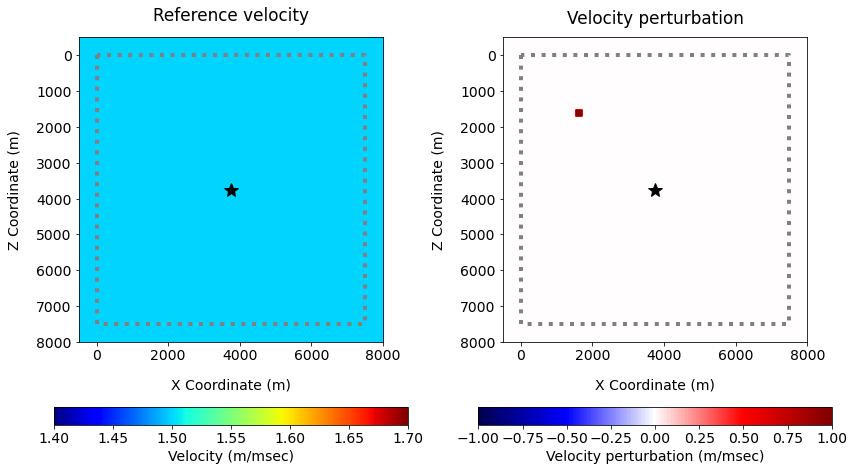

In [6]:
vmin, vmax = 1.4, 1.7
pmin, pmax = -1.0, +1.0

# note: flip sense of second dimension to make the plot positive downwards
plt_extent = [origin_pad[0], origin_pad[0] + spacing[0]*(shape_pad[0]-1), 
              origin_pad[1] + spacing[1]*(shape_pad[1]-1), origin_pad[1]]

plt.figure(figsize=(12, 8))
plt.subplots_adjust(left=0.05, right=0.95, wspace=0.2)

plt.subplot(1,2,1)
plt.imshow(np.transpose(v0.data), cmap=cm.jet, 
                   vmin=vmin, vmax=vmax, extent=plt_extent)
plt.plot([origin[0], origin[0], extent[0], extent[0], origin[0]], 
         [origin[1], extent[1], extent[1], origin[1], origin[1]], 
         'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'black', linestyle='None', marker='*', markersize=15, label="Source")
plt.colorbar(orientation='horizontal', label="Velocity (m/msec)")
plt.xlabel("X Coordinate (m)", labelpad=15)
plt.ylabel("Z Coordinate (m)", labelpad=15)
plt.title("Reference velocity", y=1.035)

plt.subplot(1,2,2)
plt.imshow(np.transpose(dv.data), cmap="seismic", 
                   vmin=pmin, vmax=pmax, extent=plt_extent)
plt.plot([origin[0], origin[0], extent[0], extent[0], origin[0]], 
         [origin[1], extent[1], extent[1], origin[1], origin[1]], 
         'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'black', linestyle='None', marker='*', markersize=15, label="Source")
plt.colorbar(orientation='horizontal', label="Velocity perturbation (m/msec)")
plt.xlabel("X Coordinate (m)", labelpad=15)
plt.ylabel("Z Coordinate (m)", labelpad=15)
plt.title("Velocity perturbation", y=1.025)
None

## Define pressure wavefields

We need two wavefields for Jacobian operations, one computed during the finite difference evolution of the nonlinear forward operator, and one computed during the finite difference evolution of the Jacobian operator. 

For this example workflow we will require saving all time steps from the nonlinear forward operator for use in the Jacobian operators. There are other ways to implement this requirement, including checkpointing, but that is beyond the scope of this illustrative workflow.  

In [7]:
# Define the TimeFunctions for nonlinear and Jacobian operations
p0 = TimeFunction(name="p0", grid=grid, time_order=2, space_order=space_order, save=True)
dp = TimeFunction(name="dp", grid=grid, time_order=2, space_order=space_order)

# Get the dimensions and spacing for t, x, z 
t,x,z = p0.dimensions
h_t = t.spacing
h_x = x.spacing
h_z = z.spacing

## Define the source injection and receiver extraction for the nonlinear operator

In [8]:
# Finally we define the source injection and receiver extraction functions 
src_term_nl = src.inject(field=p0.forward, expr=src * h_t**2 * v0**2 / b)

# Create interpolation expression for receivers
rec_term_no = rec.interpolate(expr=p0.forward)

## Finally, the Devito operator

We next transcribe the time update expression above into a Devito ```Eq```. Then we add the source injection and receiver extraction and build an ```Operator``` that will generate the c++ code for performing the model.

We copy the time update expression from above for clarity. Note we omit $s$ from the ```Eq``` below because we will be explicitly injecting the source using ```src_term```.

$$
\begin{aligned}
    P(t+\delta t) &=
        \frac{\delta t^2 v^2}{b} \left[ 
            \overleftarrow{\partial_x}\left(b\ \overrightarrow{\partial_x} P \right) +
            \overleftarrow{\partial_y}\left(b\ \overrightarrow{\partial_y} P \right) +
            \overleftarrow{\partial_z}\left(b\ \overrightarrow{\partial_z} P \right) + s
        \right] \\[5pt]
        &\quad +\ P(t) \left(2 - \frac{\delta t^2 \omega_c}{Q} \right)
        - P(t-\delta t) \left(1 - \frac{\delta t\ \omega_c}{Q} \right)
\end{aligned}
$$

In [9]:
# #NBVAL_IGNORE_OUTPUT
# eq_time_update = (h_t**2 * v**2 / b) * \
#     ((b * p.dx(x0=x+h_x/2)).dx(x0=x-h_x/2) + \
#      (b * p.dz(x0=z+h_z/2)).dz(x0=z-h_z/2)) + \
#     p * (2 - h_t**2 * wOverQ) - p.backward * (1 - h_t * wOverQ)

# stencil = Eq(p.forward, eq_time_update)

# op = Operator([stencil] + src_term + rec_term, subs=p.grid.spacing_map)

In [10]:
# # run the operator
# print("v        min/max; %+12.6e %+12.6e" % (np.min(v.data), np.max(v.data)))
# print("b        min/max; %+12.6e %+12.6e" % (np.min(b.data), np.max(b.data)))
# print("wOverQ   min/max; %+12.6e %+12.6e" % (np.min(wOverQ.data), np.max(wOverQ.data)))
# print(time_range)
# # summary = op(time=time_range.num-1, h_x=dx, h_z=dz, dt=dt)
# # print("data min/max; %+12.6e %+12.6e" % (np.min(p.data[1,:,:]), np.max(p.data[1,:,:])))

## Plot the computed wavefield

<a id="nl_refs"></a>
## References
<br>

- **A nonreflecting boundary condition for discrete acoustic and elastic wave equations** (1985)
<br>Charles Cerjan, Dan Kosloff, Ronnie Kosloff, and Moshe Resheq
<br> Geophysics, Vol. 50, No. 4
<br>https://library.seg.org/doi/pdfplus/10.1190/segam2016-13878451.1
<br>

- **Generation of Finite Difference Formulas on Arbitrarily Spaced Grids** (1988)
<br>Bengt Fornberg
<br>Mathematics of Computation, Vol. 51, No. 184
<br>http://dx.doi.org/10.1090/S0025-5718-1988-0935077-0
<br>https://web.njit.edu/~jiang/math712/fornberg.pdf
<br>

- **Self-adjoint, energy-conserving second-order pseudoacoustic systems for VTI and TTI media for reverse time migration and full-waveform inversion** (2016)
<br>Kenneth Bube, John Washbourne, Raymond Ergas, and Tamas Nemeth
<br>SEG Technical Program Expanded Abstracts
<br>https://library.seg.org/doi/10.1190/segam2016-13878451.1
